In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

In [2]:
def findFiles(path): return glob.glob(path)

In [3]:
print(findFiles('data/names/*.txt'))

['data/names/Scottish.txt', 'data/names/Polish.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/Korean.txt', 'data/names/Greek.txt', 'data/names/Chinese.txt', 'data/names/Arabic.txt', 'data/names/Dutch.txt', 'data/names/Czech.txt', 'data/names/German.txt', 'data/names/Japanese.txt', 'data/names/Vietnamese.txt', 'data/names/Portuguese.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Italian.txt', 'data/names/Russian.txt']


In [4]:
import unicodedata
import string

In [6]:
all_letters = string.ascii_letters + " .,;'"
print(all_letters)
n_letters = len(all_letters)
print(n_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
57


In [9]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [11]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
n_categories

18

In [19]:
print(len(category_lines.keys()))

for key, value in category_lines.items():
    print(key, len([item for item in value if item]))

18
Scottish 100
Polish 139
French 277
Irish 232
Korean 94
Greek 203
Chinese 268
Arabic 2000
Dutch 297
Czech 519
German 724
Japanese 991
Vietnamese 73
Portuguese 74
English 3668
Spanish 298
Italian 709
Russian 9408


In [24]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [30]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor(' '))

print(lineToTensor('JJ'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0.]])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]])


In [32]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [34]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [35]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)
#check it once more

output, next_hidden = rnn(input, hidden)

In [36]:
print(output)

tensor([[-2.8067, -2.9508, -2.8820, -2.9387, -2.7845, -3.0147, -2.9149, -2.9939,
         -2.8767, -2.8523, -2.9829, -2.8652, -2.8687, -2.8434, -2.8351, -2.8673,
         -2.8976, -2.8854]], grad_fn=<LogSoftmaxBackward>)


In [37]:
print(next_hidden)

tensor([[ 0.0260,  0.0524,  0.0817,  0.0382, -0.1346, -0.0976,  0.0201,  0.0480,
          0.0751, -0.0140, -0.0543, -0.0101,  0.0809,  0.0803,  0.0384, -0.0175,
         -0.0310,  0.0403, -0.0457,  0.0737,  0.0433,  0.0261,  0.0695,  0.0240,
         -0.0016, -0.0397,  0.0713,  0.0016, -0.0030,  0.0049, -0.0982,  0.0808,
         -0.0475, -0.0280,  0.1101,  0.0382, -0.0448, -0.0454, -0.0778, -0.0010,
          0.0758, -0.0053, -0.0688, -0.0414, -0.0568,  0.0569,  0.0302,  0.0976,
         -0.0333,  0.0158, -0.0122,  0.0411,  0.0179,  0.1132,  0.0985, -0.1004,
          0.0794, -0.0317, -0.1112,  0.1234, -0.0187, -0.0908, -0.0470,  0.0106,
          0.0026,  0.1007,  0.0149,  0.0204, -0.0308, -0.0891,  0.0851,  0.0564,
          0.0249, -0.0376,  0.0628, -0.0788,  0.1155, -0.0102,  0.1014, -0.0648,
         -0.0208, -0.1050, -0.0028,  0.0784,  0.0068,  0.0109,  0.0402, -0.0092,
         -0.0399,  0.0651, -0.0233,  0.0082,  0.0737, -0.0648,  0.0060,  0.0493,
         -0.0647,  0.0174,  

In [43]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8067, -2.9508, -2.8820, -2.9387, -2.7845, -3.0147, -2.9149, -2.9939,
         -2.8767, -2.8523, -2.9829, -2.8652, -2.8687, -2.8434, -2.8351, -2.8673,
         -2.8976, -2.8854]], grad_fn=<LogSoftmaxBackward>)


In [50]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Korean', 4)


In [54]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line, '/line_tensor =', line_tensor.shape)

category = Dutch / line = Zee /line_tensor = torch.Size([3, 1, 57])
category = Dutch / line = Schuyler /line_tensor = torch.Size([8, 1, 57])
category = Greek / line = Sakellariou /line_tensor = torch.Size([11, 1, 57])
category = Arabic / line = Nader /line_tensor = torch.Size([5, 1, 57])
category = Arabic / line = Guirguis /line_tensor = torch.Size([8, 1, 57])
category = English / line = Dukes /line_tensor = torch.Size([5, 1, 57])
category = Greek / line = Adamou /line_tensor = torch.Size([6, 1, 57])
category = Korean / line = Cho /line_tensor = torch.Size([3, 1, 57])
category = Czech / line = Korycan /line_tensor = torch.Size([7, 1, 57])
category = Spanish / line = Travieso /line_tensor = torch.Size([8, 1, 57])


In [55]:
criterion = nn.NLLLoss()

In [56]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

In [57]:
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [67]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

In [68]:
# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 5s) 1.5175 Maslanka / Polish ✓
10000 10% (0m 10s) 1.4782 Mendoza / Spanish ✓
15000 15% (0m 15s) 1.9683 Estevez / German ✗ (Spanish)
20000 20% (0m 20s) 1.2873 Harada / Japanese ✓
25000 25% (0m 27s) 0.6212 Taflambas / Greek ✓
30000 30% (0m 33s) 0.7660 Nolan / Irish ✓
35000 35% (0m 39s) 0.9238 Chu / Vietnamese ✓
40000 40% (0m 45s) 1.3294 Obuchi / Italian ✗ (Japanese)
45000 45% (0m 50s) 3.7662 Bonnay / Arabic ✗ (French)
50000 50% (0m 56s) 0.2834 Tsahalis / Greek ✓
55000 55% (1m 3s) 0.9642 Perreault / French ✓
60000 60% (1m 9s) 0.0751 Drivakis / Greek ✓
65000 65% (1m 14s) 1.5555 Nasato / Japanese ✗ (Italian)
70000 70% (1m 20s) 0.9547 Cnaimhin / Scottish ✗ (Irish)
75000 75% (1m 25s) 0.8329 Ryu / Korean ✓
80000 80% (1m 31s) 2.2986 Goring / German ✗ (English)
85000 85% (1m 36s) 0.2305 Ozaki / Japanese ✓
90000 90% (1m 42s) 0.0945 Leontarakis / Greek ✓
95000 95% (1m 47s) 0.3281 Schnur / German ✓
100000 100% (1m 53s) 1.7039 Naito / Portuguese ✗ (Japanese)


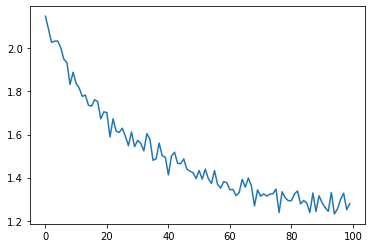

In [69]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

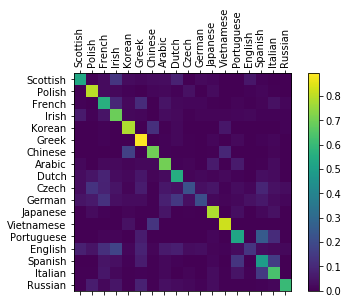

In [72]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
# plt.show()

In [73]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [75]:
predict('Dovesky')


> Dovesky
(-0.38) Russian
(-1.52) Czech
(-3.42) Irish
